(models-comparison-notebook)=
# Confronto tra modelli

I ricercatori spesso confrontano modelli alternativi di equazioni strutturali che includono le stesse variabili e sono adattati agli stessi dati. Il contesto più frequente si verifica quando un singolo modello iniziale viene testato attraverso una serie di passaggi. Ad ogni passaggio, il modello iniziale viene ridefinito aggiungendo uno o più parametri liberi, il che generalmente migliora l'adattamento, oppure eliminando (fissando a zero) uno o più parametri liberi, il che generalmente peggiora l'adattamento. Una coppia di modelli alternativi così specificata viene definita "modelli nidificati", poiché il modello più semplice dei due, o modello vincolato, è un sottoinsieme proprio del modello più complesso, o modello non vincolato. Un contesto diverso si verifica quando ci sono due o più modelli iniziali tali che (1) ogni modello si basa su una teoria diversa e (2) i modelli alternativi non sono nidificati nella loro relazione l'uno con l'altro. In entrambi i contesti, la scelta tra modelli concorrenti dovrebbe essere guidata tanto da basi concettuali quanto da considerazioni statistiche.

In [1]:
source("_common.R")
suppressPackageStartupMessages({
    library("lavaan")
    library("lavaanExtra")
    library("lavaanPlot")
    library("psych")
    library("dplyr") 
    library("tidyr")
    library("knitr")
    library("mvnormalTest")
    library("semPlot")
    library("DiagrammeRsvg")
    library("rsvg")
    library("effectsize")
})

set.seed(42)

Warning message in file(filename, "r", encoding = encoding):
“non è possibile aprire il file '_common.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): non è possibile aprire la connessione


## Confrontare Modelli nel SEM

Nel contesto dei Modelli di Equazioni Strutturali (SEM), un aspetto critico è il confronto tra diversi modelli per determinare quale sia il più adeguato. Questo confronto si presenta frequentemente nella forma di analisi di modelli nidificati. In tale contesto, si confronta un modello considerato "pieno" o "meno restrittivo" con un altro modello che è "ridotto" o "più restrittivo". 

Il modello pieno include un insieme più ampio di parametri e ipotesi, offrendo una rappresentazione più complessa delle relazioni tra le variabili. Al contrario, il modello ridotto è una versione più semplificata, con meno parametri e ipotesi, risultando in una struttura più contenuta e potenzialmente più parsimoniosa. 

Questo tipo di confronto è cruciale per valutare l'adeguatezza dei modelli SEM, permettendo ai ricercatori di decidere se la complessità aggiuntiva del modello pieno sia giustificata rispetto al modello ridotto in termini di adattamento ai dati e coerenza con la teoria sottostante.

### Analisi dei Modelli Nidificati 

Nell'ambito dei Modelli di Equazioni Strutturali (SEM), i modelli nidificati occupano un ruolo centrale. Due modelli sono definiti come nidificati quando soddisfano specifici criteri gerarchici, delineati come segue:

1. **Formazione del Modello Vincolato:**
   - Si crea un modello vincolato applicando una o più restrizioni a un modello non vincolato esistente. Questo processo aumenta i gradi di libertà del modello vincolato (C) rispetto a quelli del modello non vincolato (U), risultando in $ \text{df}_C > \text{df}_U $.

2. **Differenze nei Gradi di Libertà:**
   - La differenza $ \text{df}_C - \text{df}_U $ rappresenta il numero di restrizioni imposte al modello non vincolato per creare il modello vincolato, che equivale alla variazione nel numero di parametri liberi tra i due modelli.

3. **Parametri Liberi e Vincolati:**
   - I parametri liberi nel modello vincolato costituiscono un sottoinsieme di quelli presenti nel modello non vincolato. Allo stesso modo, i parametri fissi nel modello non vincolato formano un sottoinsieme di quelli nel modello vincolato.

4. **Confronto dei Valori di Chi-Quadro:**
   - Tra i due modelli, il valore di $ \chi^2 $ è minore o uguale nel modello non vincolato rispetto a quello nel modello vincolato, ovvero $ \chi^2_U \leq \chi^2_C $. Questo implica che le distribuzioni di probabilità possibili nel modello vincolato sono comprese anche nel modello non vincolato, che può tuttavia suggerire ulteriori distribuzioni non coerenti con il modello vincolato.

Questo tipo di relazione gerarchica, conosciuta come annidamento dei parametri, permette di valutare l'impatto di specifiche restrizioni o aggiunte di parametri. Ad esempio, un parametro libero in un modello non vincolato può essere fissato a zero, eliminando di conseguenza l'effetto corrispondente nel modello vincolato, oppure può essere sottoposto a un vincolo specificato dal ricercatore, riducendo così il numero di parametri liberi ma mantenendo l'effetto nel modello vincolato.

Consideriamo, per esempio, un modello di percorso non vincolato U con effetti diretti:
$ X \rightarrow Y_1 \rightarrow Y_2 $ e $ X \rightarrow Y_2 $.
Ridefinendo il percorso $ X \rightarrow Y_2 = 0 $, eliminiamo questa connessione dal modello U, generando così il modello vincolato C1, nidificato sotto U. Un'alternativa potrebbe essere imporre un vincolo di uguaglianza tra $ X \rightarrow Y_2 $ e $ Y_1 \rightarrow Y_2 $, indicando che gli effetti diretti non standardizzati di X e Y1 su Y2 sono identici. Questo produce un modello vincolato, C2, con un parametro libero in meno rispetto a U ma che include tutti i percorsi di U.

Nelle prossime sezioni, esamineremo come testare le ipotesi inerenti a questi modelli nidificati e come valutare la loro adeguatezza nel contesto SEM.

### Strategie di Costruzione e Potatura nei Modelli SEM

#### Costruzione Progressiva del Modello
La costruzione di modelli SEM inizia tipicamente con un modello iniziale semplice e vincolato, che riflette le ipotesi fondamentali basate su teorie sostanziali. Questo approccio, detto anche ricerca in avanti, implica l'aggiunta progressiva di parametri liberi che rappresentano ipotesi precedentemente escluse, in base alla loro importanza. Sebbene questo processo possa generalmente migliorare l'adattamento del modello (riduzione di chiML), un adattamento migliore non è necessariamente indicativo di una maggiore correttezza del modello. La costruzione del modello può teoricamente proseguire fino a quando non si raggiunge un modello perfettamente adatto ai dati (dfM = 0), ma è essenziale valutare la validità teorica e la parsimonia del modello in ogni passaggio.

#### Potatura Retrograda del Modello
In contrasto, la potatura del modello, o ricerca all'indietro, inizia con un modello più complesso e non vincolato. In questa fase, il ricercatore semplifica il modello eliminando parametri liberi (fissandoli a zero) o imponendo vincoli di stima. Questo processo richiede di dare priorità alle ipotesi in ordine inverso di importanza. Il modello iniziale dovrebbe essere congruente con i dati, altrimenti non ha senso restringerlo ulteriormente. Tipicamente, come si procede con la potatura, l'adattamento complessivo del modello ai dati tende a peggiorare (aumento di chiML). Il criterio per arrestare la potatura si basa sull'adattamento del modello: si ferma quando ulteriori restrizioni peggiorerebbero significativamente l'adattamento ai dati.

#### Obiettivi e Considerazioni
L'obiettivo sia nella costruzione che nella potatura di modelli è identificare un modello con una struttura di covarianza (e, se presente, anche di media) correttamente specificata e teoricamente giustificata. Idealmente, entrambi gli approcci dovrebbero convergere verso lo stesso modello ottimale, benché ciò non sia garantito. È importante evitare il rischio di formulare ipotesi post hoc (HARKing), presentando modelli scoperti in modo esplorativo come se fossero stati ipotizzati a priori. Una soluzione a questo problema è la preregistrazione del piano di analisi.

#### Punti di Forza Relativi
1. **Costruzione del Modello:** Partire da un modello più semplice può essere vantaggioso, soprattutto per i neofiti del SEM, poiché facilita l'identificazione statistica e riduce il rischio di errori nella specificazione del modello.
2. **Potatura del Modello:** Questo approccio può essere particolarmente efficace per i modelli di misurazione, dove le variabili osservate sono usate come indicatori di un numero limitato di fattori comuni. Un modello di misurazione correttamente specificato inizialmente può rendere la potatura più efficace rispetto alla costruzione.

In entrambi i casi, è cruciale basare le decisioni su solide basi teoriche oltre che su considerazioni statistiche, per assicurare che il modello finale sia non solo adatto ai dati ma anche coerente con il quadro teorico sottostante.

### Strategie di Ridefinizione dei Modelli SEM: Approcci Teorici ed Empirici

#### Approccio Teorico nella Ridefinizione dei Modelli
Nel processo di costruzione o potatura dei Modelli di Equazioni Strutturali (SEM), l'approccio teorico gioca un ruolo fondamentale. Qui, le modifiche al modello sono guidate da ipotesi teoriche predefinite e specifiche. Ad esempio, considerando un modello di percorso non vincolato U con le relazioni $X \rightarrow Y_1 \rightarrow Y_2$ e $X \rightarrow Y_2$, un ricercatore potrebbe ipotizzare che l'effetto di X su Y2 sia esclusivamente indiretto attraverso Y1. Questa ipotesi può essere testata vincolando il coefficiente di $X \rightarrow Y_2$ a zero. Se l'adattamento del modello così modificato non è significativamente inferiore rispetto al modello non vincolato, l'ipotesi di un effetto indiretto viene supportata, a patto che la direzionalità delle relazioni sia corretta.

Questo approccio enfatizza che le modifiche al modello dovrebbero essere effettuate sulla base di solide basi teoriche e concettuali, piuttosto che su criteri puramente statistici, come evidenziato da Jöreskog (1969): "La decisione di smettere di aggiungere parametri non può basarsi solo su una base statistica; ciò dipende in gran parte dall'interpretazione dei dati da parte del ricercatore, basata su considerazioni teoriche e concettuali sostanziali."

#### Approccio Empirico nella Ridefinizione dei Modelli
Al contrario, l'approccio empirico nella costruzione o potatura dei modelli SEM si basa su criteri statistici. In questo scenario, i parametri liberi vengono aggiunti o eliminati a seconda della loro significatività statistica o di altri indicatori empirici. Per esempio, se i percorsi sono eliminati solo perché i loro coefficienti non sono statisticamente significativi, la ridefinizione del modello è guidata da considerazioni puramente empiriche. Questo approccio è analogo alla tecnica di eliminazione all'indietro nella regressione multipla, dove il software sceglie quali predittori rimuovere in base a criteri di significatività statistica.

#### Implicazioni per l'Interpretazione dei Modelli
La scelta tra un approccio teorico o empirico nella ridefinizione dei modelli SEM ha implicazioni significative per come interpretiamo i risultati. Un modello modificato in base a criteri teorici forti offre una maggiore fiducia nella validità delle sue conclusioni, mentre un modello costruito o potato basandosi principalmente su criteri empirici può essere soggetto a errori di Tipo I o II e può non essere replicabile in campioni diversi.

È fondamentale che i ricercatori si avvicinino alla costruzione e alla potatura dei modelli SEM con un equilibrio tra intuizioni teoriche e risultati empirici, per assicurare che i modelli finali siano non solo statisticamente validi ma anche teoricamente giustificati e interpretativamente significativi.

### Test della Differenza Chi-Quadro nel SEM

#### Principi Fondamentali
Il test della differenza Chi-Quadro (chiD) è una tecnica statistica essenziale nel contesto dei Modelli di Equazioni Strutturali (SEM) per valutare l'effetto delle modifiche ai parametri sui modelli. Questo test viene utilizzato sia nella potatura (restrizione dei parametri) che nella costruzione (aggiunta di parametri) dei modelli. Il valore chiD rappresenta la differenza tra i valori di chi-quadro (chi-quadro massima verosimiglianza, chiML) di due modelli nidificati. I gradi di libertà associati, dfD, sono determinati dalla differenza nei gradi di libertà dei due modelli ($ \text{df}_C - \text{df}_U $).

#### Applicazione del Test
Per applicare il test della differenza chi-quadro, si seguono questi passaggi:
1. **Definizione dei Modelli:** Identificare il modello pieno (con tutti i parametri ritenuti rilevanti) e il modello ridotto (una versione semplificata del modello pieno con alcune restrizioni).
2. **Stima dei Modelli:** Utilizzare metodi di massima verosimiglianza per stimare entrambi i modelli.
3. **Calcolo del Rapporto di Verosimiglianze:** Calcolare la differenza tra i logaritmi delle funzioni di verosimiglianza dei due modelli ($ D = -2(\ln(L_r) - \ln(L_f)) $).
4. **Test Statistico:** Utilizzare la distribuzione chi-quadrato per determinare il p-value. Un p-value basso indica che il modello ridotto non si adatta ai dati così come il modello pieno.

#### Interpretazione dei Risultati
Un valore piccolo di chiD suggerisce che non c'è una differenza significativa nell'adattamento tra i due modelli, mentre un valore grande indica una differenza significativa. In termini di potatura, un grande chiD implica che il modello è stato eccessivamente vincolato. Nella costruzione, un grande chiD supporta la conservazione del parametro libero aggiunto. Tuttavia, prima di trarre conclusioni definitive, è cruciale considerare l'adattamento complessivo del modello, sia a livello globale che locale.

#### Considerazioni nella Stima ML Robusta
Nel caso di stima ML robusta, la differenza tra i chi-quadri scalati non può essere interpretata come un test dell'ipotesi di adattamento uguale a causa delle distribuzioni non centrali in condizioni di non normalità. Sono disponibili metodi specifici per calcolare una statistica di differenza chi-quadro scalata che segue approssimativamente le distribuzioni chi-quadro.

#### Implicazioni Teoriche ed Empiriche
La decisione di modificare un modello basandosi su un approccio teorico o empirico ha implicazioni significative. Ad esempio, l'eliminazione di percorsi non significativi su base puramente statistica può portare a conclusioni errate se non supportate da una solida base teorica. Inoltre, è importante essere consapevoli dei rischi associati alla capitalizzazione sul caso, come errori di Tipo I e II, e del pericolo di seguire "sentieri che si biforcano" nelle decisioni analitiche, che possono rendere i risultati specifici del campione e difficili da replicare. Per mitigare questi rischi, è consigliabile basare le modifiche del modello più su orientamenti teorici che sui risultati dei test di significatività.

### Test della Differenza Chi-Quadro Scalato

Il metodo di Satorra e Bentler (2001) permette di calcolare manualmente una statistica di differenza chi-quadro scalata quando si confrontano due modelli gerarchici nella stima ML robusta. Si presume che il modello 1 sia più vincolato rispetto al modello 2 (cioè, dfM1 > dfM2), i chi-quadri non scalati siano chiML e i chi-quadri scalati siano chiSB. La statistica di test Satorra-Bentler è definita come segue:
1. **Calcolare la Statistica di Differenza Chi-Quadro non Scalata e i suoi Gradi di Libertà:** 
   - chiD = chiML1 - chiML2 e dfD = dfM1 - dfM2.
2. **Recuperare il Fattore di Correzione di Scala, c, per Ogni Modello:**
   - c1 = chiML1 / chiSB1 e c2 = chiML2 / chiSB2.
3. **Calcolare la Statistica di Differenza Chi-Quadro Scalata, chiSD:**
   - chiSD = chiD / ((c1 / dfM1 - c2 / dfM2) / dfD).
   - La probabilità per chiSD (dfD) in una distribuzione chi-quadro centrale rappresenta il p-value per il test di differenza chi-quadro scalato.

In campioni piccoli o quando il modello più vincolato è molto errato, il denominatore di chiSD può essere < 0, invalidando il test. Questo test è implementato nella funzione `lavTestLRT()` in `lavaan` (Rosseel et al., 2023).

## Esempio

Consideriamo nuovamente i dati discussi da {cite:t}`brown2015confirmatory` relativi al modello di misurazione per la depressione maggiore così come è definita nel DSM-IV. Ignoriamo qui le differenze di genere -- si veda il Capitolo {ref}`factorial-invariance-notebook`. Leggiamo i dati in $\mathsf{R}$:

In [3]:
d_mdd <- readRDS(
    here::here("data", "mdd_sex.RDS")
)

Consideriamo il seguente modello:

In [4]:
model_mdd <- "
  MDD =~ mdd1 + mdd2 + mdd3 + mdd4 + mdd5 + mdd6 + mdd7 + mdd8 + mdd9
"

Adattiamo il modello ai dati.

In [5]:
fit_mdd <- cfa(
    model_mdd,
    data = d_mdd
)

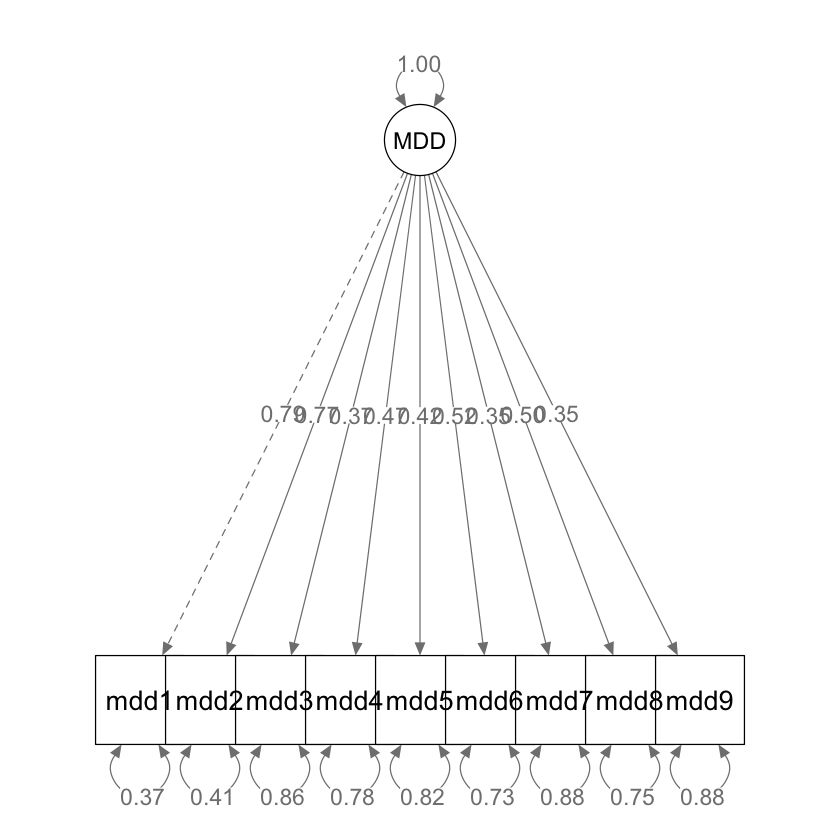

In [6]:
semPaths(fit_mdd,
    whatLabels = "std",
    sizeMan = 10,
    edge.label.cex = 1.15,
    style = "ram",
    nCharNodes = 0, nCharEdges = 0
)

In [7]:
fitMeasures(fit_mdd) |>
    print()

                 npar                  fmin                 chisq 
               18.000                 0.074               110.272 
                   df                pvalue        baseline.chisq 
               27.000                 0.000              1297.618 
          baseline.df       baseline.pvalue                   cfi 
               36.000                 0.000                 0.934 
                  tli                  nnfi                   rfi 
                0.912                 0.912                 0.887 
                  nfi                  pnfi                   ifi 
                0.915                 0.686                 0.934 
                  rni                  logl     unrestricted.logl 
                0.934            -13747.192            -13692.056 
                  aic                   bic                ntotal 
            27530.385             27613.546               750.000 
                 bic2                 rmsea        rmsea.ci.lo

Gli indici Comparative Fit Index (CFI) = 0.934 e Tucker-Lewis Index (TLI) = 0.912 sono superiori a 0.9, dunque sono almeno sufficienti per gli standard correnti. L'indice RMSEA = 0.064 è appena superiore alla soglia di 0.06. L'indice SRMR = 0.044 è inferiore alla soglia 0.05. Dunque, complessivamente, il modello sembra adeguato.

Adattiamo ora il modello con la modifica proposta da {cite:t}`brown2015confirmatory`, ovvero

In [8]:
model2_mdd <- "
  MDD =~ mdd1 + mdd2 + mdd3 + mdd4 + mdd5 + mdd6 + mdd7 + mdd8 +  mdd9
  mdd1 ~~ mdd2
"

fit2_mdd <- cfa(
    model2_mdd,
    data = d_mdd
)

Eseguiamo il test del rapporto di verosimiglianze:

In [10]:
lavTestLRT(fit_mdd, fit2_mdd)

,Df,AIC,BIC,Chisq,Chisq diff,RMSEA,Df diff,Pr(>Chisq)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
fit2_mdd,26,27489.67,27577.45,67.55856,NA,NA,NA,NA
fit_mdd,27,27530.38,27613.55,110.27242,42.71385,0.2358357,1,6.336194e-11


Il test indica che il modello alternativo si adatta meglio ai dati del modello originale.

Esaminiamo gli indici di bontà di adattamento.

In [11]:
effectsize::interpret(fit2_mdd)

Name,Value,Threshold,Interpretation
<chr>,<dbl>,<dbl>,<effctsz_>
GFI,0.97807123,0.95,satisfactory
AGFI,0.96204635,0.90,satisfactory
NFI,0.94793648,0.90,satisfactory
NNFI,0.95438982,0.90,satisfactory
CFI,0.96705932,0.90,satisfactory
RMSEA,0.04616501,0.05,satisfactory
SRMR,0.03675390,0.08,satisfactory
RFI,0.92791205,0.90,satisfactory
PNFI,0.68462079,0.50,satisfactory


Gli indici Comparative Fit Index (CFI) = 0.967 e Tucker-Lewis Index (TLI) = 0.954 sono superiori a 0.95. L'indice RMSEA = 0.046. L'indice SRMR = 0.037. 

Il "costo" che si paga per questo miglioramento dell'adattamento è che indici di adattamento così buoni, probabilmente, non si replicheranno in un altro campione di dati, a meno che venga introdotto un qualche altro aggiustamento che, sicuramente, sarà diverso da quello usato nel campione corrente. Personalmente, non avrei introdotto il "miglioramento" proposto da {cite:t}`brown2015confirmatory` in quanto, anche senza un tale aggiustamento post-hoc, il modello produce un adattamento accettabile.

### Confronto di Modelli Non Annidati

### Revisione del Testo: Confronto tra Modelli Non Annidati

Proseguendo, analizzeremo l'adattamento di due modelli distinti, entrambi costituiti dalle stesse variabili e applicati agli stessi dati. Tuttavia, a differenza di quanto precedentemente delineato, questi modelli non sono collegati gerarchicamente, ma si configurano come modelli non annidati. Questa situazione si presenta comunemente quando i ricercatori mettono a confronto modelli basati su teorie divergenti. È possibile effettuare un confronto informale dei valori del chi-quadrato derivanti da modelli non annidati, ma la loro differenza non va interpretata come una statistica di test valida. In altre parole, i test di differenza del chi-quadrato, sia in forma scalata che non, non sono appropriati in questo contesto. La ragione risiede nel fatto che la differenza tra le statistiche di test di modelli non annidati non segue una distribuzione chi-quadrato centrale. Sebbene siano stati compiuti sforzi per elaborare test di significatività adatti al confronto di modelli non annidati, questi metodi non hanno trovato un ampio utilizzo e spesso portano a complicazioni interpretative (Levy & Hancock, 2007).

Una soluzione più pragmatica è rappresentata dalla famiglia degli indici di adattamento predittivo, conosciuti anche come criteri teorico-informativi. Questi indici non sono test di significatività, poiché le loro distribuzioni di probabilità variano ampiamente a seconda del tipo di modello e dei dati considerati e, pertanto, rimangono generalmente ignote. Piuttosto, essi riflettono sia la qualità dell'adattamento del modello sia la sua complessità, bilanciando questi due aspetti. Ciò implica l'applicazione di una penalità per la complessità del modello, che consente di regolare l'adattamento in funzione del numero di parametri liberi. Per esempio, nel caso di due modelli non annidati che mostrano un adattamento simile agli stessi dati, verrà privilegiato il modello meno complesso, in quanto considerato più probabile nella generalizzazione su campioni replicati. In questo scenario, il valore del criterio informativo sarà inferiore per il modello più semplice, dato che una penalità maggiore per la complessità viene applicata all'adattamento del modello più complesso. Di conseguenza, il modello con il criterio informativo più basso è da preferire. In questo capitolo, dopo aver introdotto un problema di ricerca, esploreremo due indici di adattamento predittivo ampiamente usati (AIC e BIC).

```{figure} images/romney.png
---
height: 550px
name: romney-fig
---
Modelli alternativi non annidati di percorso ricorsivo per l'adattamento dopo un intervento chirurgico cardiaco.  (Figura tratta da {cite:t}`kline2023principles`).
```

Nella figura sono presentati due modelli di percorso che descrivono il recupero dei pazienti dopo un intervento chirurgico cardiaco (Romney et al., 1992) -- si veda {cite:t}`kline2023principles`, cap. 11. Il modello psicosomatico rappresenta le ipotesi che il morale del paziente trasmetta gli effetti della disfunzione neurologica e dello stato socioeconomico ridotto (SES) su sintomi della malattia e scarse relazioni sociali. Il modello medico rappresenta un diverso schema di relazioni causali tra le stesse variabili. In particolare, sia i sintomi della malattia sia la disfunzione neurologica sono specificati come variabili esogene con effetti diretti sul SES ridotto, basso morale e scarse relazioni. Tra queste tre variabili endogene, si ipotizza che il SES ridotto influenzi indirettamente le scarse relazioni attraverso il suo impatto precedente sul basso morale. Ci sono ulteriori effetti indiretti nel modello medico convenzionale dalle variabili esogene a quelle endogene. I due modelli nella figura non sono annidati, quindi il test della differenza del chi-quadro non può essere utilizzato per confrontarli direttamente. È dunque necessario seguire un altro approccio.

## AIC e BIC

Uno degli indici di adattamento predittivo più noti basato sulla stima di massima verosimiglianza (ML) è il Criterio di Informazione di Akaike (AIC), che prende il nome dallo statistico Hirotugu Akaike. La formula per l'AIC di Akaike (1974, p. 719) è:

$$ \text{AIC} = -2 \ln L_0 + 2q $$

dove $ L_0 $ è la funzione di verosimiglianza massimizzata nella stima ML per il modello del ricercatore e $ q $ è il numero di parametri liberi del modello. Si noti che la penalità per la complessità nell'equazione precedente, $ 2q $, diventa relativamente più piccola all'aumentare della dimensione del campione (Mulaik, 2009b). 

Un diverso indice teorico-informativo che tiene direttamente conto della dimensione del campione è il Criterio di Informazione Bayesiano (BIC) (Raftery, 1993; Schwarz, 1978). La formula è

$$ \text{BIC} = -2 \ln L_0 + q \ln N $$

Confrontato con l'AIC, il BIC impone una penalità relativa maggiore per la complessità del modello. 

Supponiamo che il numero di parametri stimati liberamente sia $ q = 10 $ e che $ N = 300 $. La penalità AIC equivale a $ 2(10) $, ovvero 20.000 (Equazione 11.4), ma la penalità BIC per lo stesso modello è $ 10 (\ln 300) $, ovvero 50.038, più del doppio rispetto all'AIC. I valori relativi delle penalità BIC aumentano più lentamente all'aumentare della dimensione del campione; in altre parole, la sua penalità è asintotica su campioni sempre più grandi (Mulaik, 2009b).

In sostanza, sia l'AIC che il BIC sono strumenti per bilanciare l'adattamento del modello con la sua complessità, ma differiscono nel modo in cui valutano e penalizzano questa complessità, soprattutto in relazione alla dimensione del campione.

Utilizzando lo script fornito da {cite:t}`kline2023principles`, iniziamo a importare i dati in `R`:

In [25]:
# input the correlations in lower diagnonal form
romneyLower.cor <- "
 1.00
  .53 1.00
  .15  .18 1.00
  .52  .29 -.05 1.00
  .30  .34  .23  .09 1.00 "

# name the variables and convert to full correlation matrix
romney.cor <- lavaan::getCov(romneyLower.cor, names = c(
    "morale", "symptoms",
    "dysfunction", "relations", "ses"
))

Esaminiamo le matrici di correlazioni e covarianze:

In [26]:
# display the correlations
romney.cor

,morale,symptoms,dysfunction,relations,ses
morale,1.00,0.53,0.15,0.52,0.30
symptoms,0.53,1.00,0.18,0.29,0.34
dysfunction,0.15,0.18,1.00,-0.05,0.23
relations,0.52,0.29,-0.05,1.00,0.09
ses,0.30,0.34,0.23,0.09,1.00


In [27]:
# add the standard deviations and convert to covariances
romney.cov <- lavaan::cor2cov(romney.cor, sds = c(
    3.75, 17.00, 19.50,
    3.50, 24.70
))

# display the covariances
romney.cov

,morale,symptoms,dysfunction,relations,ses
morale,14.06250,33.7875,10.96875,6.8250,27.7875
symptoms,33.78750,289.0000,59.67000,17.2550,142.7660
dysfunction,10.96875,59.6700,380.25000,-3.4125,110.7795
relations,6.82500,17.2550,-3.41250,12.2500,7.7805
ses,27.78750,142.7660,110.77950,7.7805,610.0900


Specifichiamo il modello psicosomatico.

In [28]:
somatic.model <- "
# regressions
 morale ~ ses + dysfunction
 relations ~ morale
 symptoms ~ morale
# without the zero constraint listed next,
# lavaan automatically specifies correlated
# disturbances for symptoms and relations,
# but their disturbances are independent in
# figure 11.1
 symptoms ~~ 0*relations
# unanalyzed association between ses and dysfunction
# automatically specified "

Specifichiamo il modello medico convenzionale.

In [29]:
medical.model <- "
# regressions
 ses ~ symptoms + dysfunction
 morale ~ symptoms + ses
 relations ~ dysfunction + morale
# unanalyzed association between symptoms and dysfunction
# automatically specified "

Adattiamo ai dati il modello psicosomatico.

In [30]:
somatic <- lavaan::sem(somatic.model,
    sample.cov = romney.cov,
    sample.nobs = 469, fixed.x = FALSE, sample.cov.rescale = FALSE
)

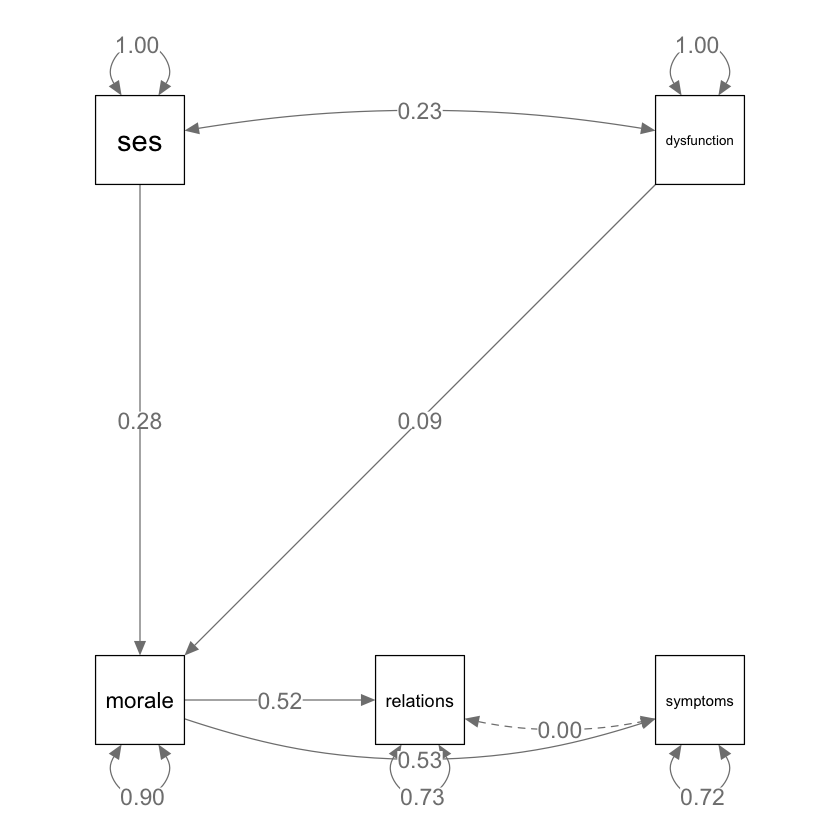

In [31]:
semPaths(somatic,
    whatLabels = "std",
    sizeMan = 10,
    edge.label.cex = 1.15,
    style = "ram",
    nCharNodes = 0, nCharEdges = 0
)

In [32]:
lavaan::summary(somatic, fit.measures = TRUE, rsquare = TRUE) |> print()

lavaan 0.6.17 ended normally after 1 iteration

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        10

  Number of observations                           469

Model Test User Model:
                                                      
  Test statistic                                40.488
  Degrees of freedom                                 5
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                               390.816
  Degrees of freedom                                 9
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.907
  Tucker-Lewis Index (TLI)                       0.833

Loglikelihood and Information Criteria:

  Loglikelihood user model (H0)              -8572.844
  Loglikelihood unrestricted model (H1)      -8552

Ora approfondiamo l'analisi dei residui. Nel contesto di un modello SEM, i residui sono derivati dalle differenze tra la matrice di correlazioni (o covarianze) osservata e quella prevista dal modello. Queste differenze sono elaborate attraverso specifiche funzioni per generare i residui. Utilizzando il pacchetto `lavaan` in R, possiamo accedere a tre principali tipi di residui: `standardized.mplus`, `normalized`, e `cor.bollen`. 

1. **Residui Standardizzati (Standardized.mplus)**: Questo tipo di residuo è una versione standardizzata dei residui. I residui standardizzati sono ottenuti calcolando la differenza tra i valori osservati e quelli previsti dal modello, e dividendo questa differenza per uno stimatore della deviazione standard del residuo. Questo processo trasforma i residui in una scala in cui hanno una varianza approssimativamente uguale. I residui standardizzati sono utili per identificare punti dati che il modello non riesce a spiegare bene. In `lavaan`, `type = "standardized.mplus"` si riferisce a una particolare forma di standardizzazione dei residui, simile a quella utilizzata nel software Mplus.

2. **Residui Normalizzati (Normalized)**: I residui normalizzati sono un altro tipo di residui standardizzati. Sono calcolati come i residui standardizzati ma poi vengono normalizzati. La normalizzazione qui significa che i residui vengono ulteriormente trasformati in modo che la loro distribuzione si avvicini a una distribuzione normale. Questo è utile per verificare se i residui seguono una distribuzione normale, il che è un'assunzione comune in molti modelli statistici, inclusi quelli SEM.

3. **Correlazione dei Residui secondo Bollen (Cor.bollen)**: Questo tipo di residuo si riferisce alla correlazione tra i residui di due variabili diverse nel modello. Il metodo `cor.bollen` calcola la correlazione tra i residui dopo che il modello è stato adattato ai dati. Questo tipo di analisi è utile per rilevare se ci sono correlazioni non modellate tra le variabili che potrebbero influenzare la validità del modello. 

In [33]:
# print residuals
lavaan::residuals(somatic, type = "standardized.mplus")
lavaan::residuals(somatic, type = "normalized")
lavaan::residuals(somatic, type = "cor.bollen")

,morale,relations,symptoms,ses,dysfunction
morale,0.000000e+00,-8.881784e-16,0.000000,0.000000,0.000000
relations,-8.881784e-16,1.776357e-15,0.427235,-1.776002,-3.290710
symptoms,0.000000e+00,4.272350e-01,0.000000,4.542284,2.549111
ses,0.000000e+00,-1.776002e+00,4.542284,0.000000,0.000000
dysfunction,0.000000e+00,-3.290710e+00,2.549111,0.000000,0.000000


,morale,relations,symptoms,ses,dysfunction
morale,0.000000e+00,-8.881784e-16,0.000000,0.000000,0.000000
relations,-8.881784e-16,1.776357e-15,0.299512,-1.423569,-2.768562
symptoms,0.000000e+00,2.995120e-01,0.000000,3.711169,2.142044
ses,0.000000e+00,-1.423569e+00,3.711169,0.000000,0.000000
dysfunction,0.000000e+00,-2.768562e+00,2.142044,0.000000,0.000000


,morale,relations,symptoms,ses,dysfunction
morale,0.000000e+00,-1.110223e-16,0.0000,0.000,0.0000
relations,-1.110223e-16,-3.330669e-16,0.0144,-0.066,-0.1280
symptoms,0.000000e+00,1.440000e-02,0.0000,0.181,0.1005
ses,0.000000e+00,-6.600000e-02,0.1810,0.000,0.0000
dysfunction,0.000000e+00,-1.280000e-01,0.1005,0.000,0.0000


Adattiamo ai dati il modello medico convenzionale.

In [34]:
medical <- lavaan::sem(medical.model,
    sample.cov = romney.cov,
    sample.nobs = 469, fixed.x = FALSE, sample.cov.rescale = FALSE
)

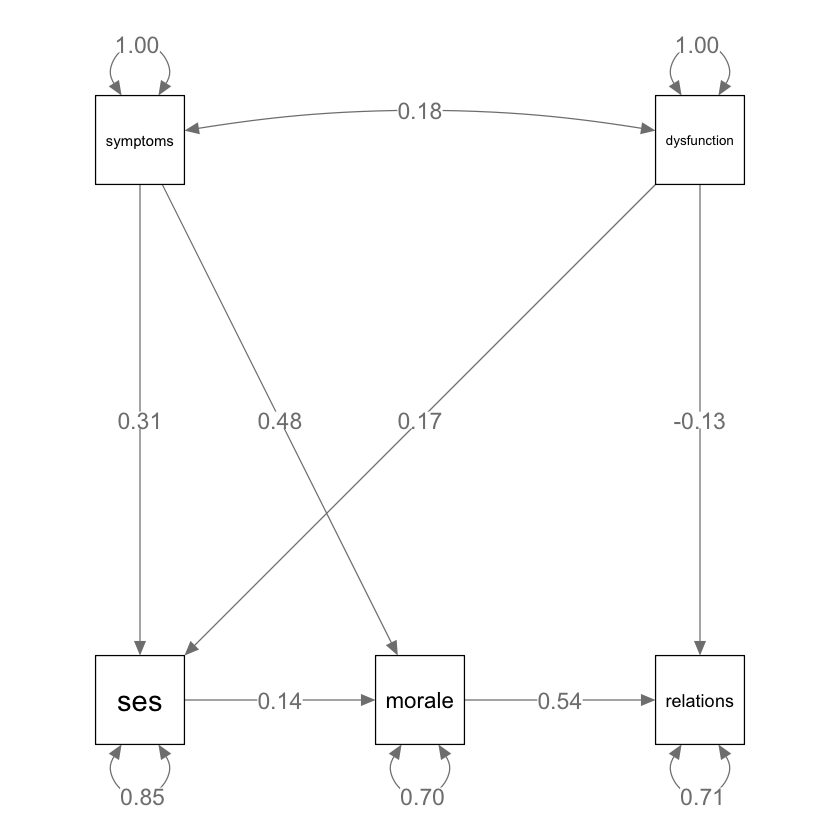

In [35]:
semPaths(medical,
    whatLabels = "std",
    sizeMan = 10,
    edge.label.cex = 1.15,
    style = "ram",
    nCharNodes = 0, nCharEdges = 0
)

In [36]:
lavaan::summary(medical, fit.measures = TRUE, rsquare = TRUE) |> print()

lavaan 0.6.17 ended normally after 1 iteration

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        12

  Number of observations                           469

Model Test User Model:
                                                      
  Test statistic                                 3.245
  Degrees of freedom                                 3
  P-value (Chi-square)                           0.355

Model Test Baseline Model:

  Test statistic                               400.859
  Degrees of freedom                                 9
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.999
  Tucker-Lewis Index (TLI)                       0.998

Loglikelihood and Information Criteria:

  Loglikelihood user model (H0)              -8554.222
  Loglikelihood unrestricted model (H1)      -8552

In [37]:
# print residuals
lavaan::residuals(medical, type = "standardized.mplus")
lavaan::residuals(medical, type = "normalized")
lavaan::residuals(medical, type = "cor.bollen")

,ses,morale,relations,symptoms,dysfunction
ses,0.000000e+00,0.000000e+00,-1.1606492,0.000000e+00,0.0000000
morale,3.552714e-15,1.776357e-15,-1.8183928,7.105427e-15,0.8421545
relations,-1.160649e+00,-1.818393e+00,NA,8.329954e-01,0.8623327
symptoms,0.000000e+00,7.105427e-15,0.8329954,0.000000e+00,0.0000000
dysfunction,0.000000e+00,8.421545e-01,0.8623327,0.000000e+00,0.0000000


,ses,morale,relations,symptoms,dysfunction
ses,0.000000e+00,0.000000e+00,-0.90105315,0.000000e+00,0.0000000
morale,3.552714e-15,1.776357e-15,-0.07984379,7.105427e-15,0.6796519
relations,-9.010531e-01,-7.984379e-02,-0.06868029,5.732348e-01,0.3704092
symptoms,0.000000e+00,7.105427e-15,0.57323484,0.000000e+00,0.0000000
dysfunction,0.000000e+00,6.796519e-01,0.37040916,0.000000e+00,0.0000000


,ses,morale,relations,symptoms,dysfunction
ses,0.000000e+00,-5.551115e-17,-0.041480422,0.00000000,0.00000000
morale,-5.551115e-17,-2.220446e-16,-0.002984041,0.00000000,0.03173451
relations,-4.148042e-02,-2.984041e-03,0.000000000,0.02814665,0.01697525
symptoms,0.000000e+00,0.000000e+00,0.028146649,0.00000000,0.00000000
dysfunction,0.000000e+00,3.173451e-02,0.016975249,0.00000000,0.00000000


In conclusione, i valori i valori degli indici di adattamento predittivo per i due modelli alternativi di Romney et al. (1992) sono stati generati seguendo le istruzioni precedentemente descritte. Non sorprende che l'adattamento globale del modello medico convenzionale, più complesso (con $ dfM = 3 $), sia migliore rispetto a quello del modello psicosomatico, più semplice (con $ dfM = 5 $). Nonostante il modello medico convenzionale sia più complesso e quindi soggetto a una penalità maggiore per il minor numero di gradi di libertà, i valori ottenuti sia nell'AIC che nel BIC sono inferiori rispetto a quelli del modello psicosomatico. Questo indica che il vantaggio in termini di adattamento del modello medico convenzionale è sufficiente a superare la penalità per la sua maggiore complessità. In base a queste analisi, il modello medico convenzionale è considerato più adatto rispetto al modello psicosomatico, come evidenziato dai valori più bassi nei criteri AIC e BIC.

## Indici di Modifica e Statistiche Correlate nel SEM

Nell'elaborazione di modelli SEM (Structural Equation Modeling), esiste la possibilità di implementare modifiche attraverso processi automatizzati. Questi interventi, di carattere esplorativo, si basano sull'aggiunta o sulla rimozione di parametri seguendo criteri empirici, come la significatività statistica di un indice di modifica (MI) o di un test di punteggio. Gli indici di modifica, in particolare, sono calcolati per quei parametri che nel modello sono stati inizialmente vincolati e servono a stimare quanto il chi-quadrato del modello di massima verosimiglianza (chiML) si ridurrebbe se un dato parametro vincolato venisse liberato.

Il meccanismo di modifica automatica opera liberando, ad ogni iterazione, il parametro vincolato che presenta il valore di MI più alto. Questo processo continua finché non si raggiunge un MI che è statisticamente significativo secondo i criteri stabiliti dal ricercatore. È cruciale, tuttavia, riconoscere che l'uso di questa metodologia, specialmente in campioni di piccole dimensioni, può portare alla formulazione di modelli che si basano eccessivamente sul caso. Di conseguenza, questi modelli potrebbero risultare poco robusti e difficilmente replicabili in studi successivi. L'automazione nel processo di ottimizzazione dei modelli SEM richiede dunque un'attenta valutazione del contesto e della dimensione del campione per garantire l'affidabilità e la validità dei risultati ottenuti.

Un altro strumento di uso frequente nei SEM è il test di Wald, basato sulla statistica W. Questo test è progettato per valutare l'impatto che avrebbe la fissazione a zero di un parametro precedentemente stimato liberamente nel modello. In termini più tecnici, il test di Wald stima l'incremento che si verificherebbe nel chi-quadrato del modello di massima verosimiglianza (chiML) se tale parametro fosse "potato", ovvero escluso dal modello.

Similmente ai processi di modifica automatica, l'efficacia del test di Wald può essere influenzata dalla casualità. Un aspetto cruciale da considerare è la sensibilità di questi test alla dimensione del campione. Infatti, anche piccole modifiche nella bontà di adattamento del modello possono assumere una significatività statistica notevole in campioni di ampie dimensioni.

Di conseguenza, quando si valutano gli indici di modifica come il MI (Modifica Index), è essenziale che il ricercatore non si limiti a considerarne la sola significatività statistica. È importante anche valutare l'entità del cambiamento che si verificherebbe nel coefficiente del parametro se fosse liberato. Se il cambiamento previsto è minimo, la significatività statistica dell'indice di modifica potrebbe essere più indicativa della dimensione del campione che non della sostanziale rilevanza dell'effetto analizzato. Questa considerazione sottolinea l'importanza di un approccio olistico e critico nell'interpretazione dei risultati dei test diagnostici in SEM, specialmente in contesti dove la dimensione del campione può influenzare significativamente i risultati.

In [38]:
fit_mdd <- cfa(
    model_mdd,
    data = d_mdd
)

Calcoliamo gli indici di modifica.

In [39]:
modification_indices <- lavInspect(fit_mdd, "mi")
modification_indices |> print()

    lhs op  rhs     mi    epc sepc.lv sepc.all sepc.nox
20 mdd1 ~~ mdd2 46.877  0.732   0.732    0.560    0.560
21 mdd1 ~~ mdd3  4.996 -0.211  -0.211   -0.108   -0.108
22 mdd1 ~~ mdd4  4.625 -0.215  -0.215   -0.108   -0.108
23 mdd1 ~~ mdd5  7.797 -0.266  -0.266   -0.137   -0.137
24 mdd1 ~~ mdd6  6.434 -0.236  -0.236   -0.132   -0.132
25 mdd1 ~~ mdd7  0.293  0.053   0.053    0.026    0.026
26 mdd1 ~~ mdd8  5.046 -0.219  -0.219   -0.116   -0.116
27 mdd1 ~~ mdd9  5.385  0.187   0.187    0.111    0.111
28 mdd2 ~~ mdd3  1.435 -0.138  -0.138   -0.055   -0.055
29 mdd2 ~~ mdd4 10.931 -0.402  -0.402   -0.158   -0.158
30 mdd2 ~~ mdd5  5.835 -0.281  -0.281   -0.113   -0.113
31 mdd2 ~~ mdd6  2.235 -0.169  -0.169   -0.074   -0.074
32 mdd2 ~~ mdd7  0.394 -0.076  -0.076   -0.029   -0.029
33 mdd2 ~~ mdd8  0.027 -0.019  -0.019   -0.008   -0.008
34 mdd2 ~~ mdd9  2.070 -0.142  -0.142   -0.066   -0.066
35 mdd3 ~~ mdd4 16.199  0.591   0.591    0.155    0.155
36 mdd3 ~~ mdd5  3.298  0.258   0.258    0.069  

Nel modello che stiamo analizzando, l'indice di modifica (MI) più elevato si riferisce alla possibile modifica del parametro che governa la correlazione tra i residui degli indicatori `mm1` e `mm2`. Nel modello `model_mdd` questa correlazione residua è impostata a zero, indicando l'assenza di una correlazione diretta tra questi residui. Tuttavia, l'indice di modifica suggerisce che se permettessimo a questa correlazione di essere stimata liberamente dal modello (anziché tenerla fissa a zero), si verificherebbe un miglioramento dell'adattamento del modello ai dati osservati. Questa osservazione è in linea con il modello alternativo che è stato proposto per questi dati proposto da {cite:t}`brown2015confirmatory`. 

Incorporare una correlazione residua tra  `mm1` e `mm2` significa riconoscere che, oltre alla variazione spiegata dalle variabili latenti comuni, esiste una relazione unica tra questi due indicatori che non è catturata dal modello. Tale relazione potrebbe essere dovuta a fattori specifici relativi a questi indicatori o a una misurazione comune non prevista dal modello originale.

È importante sottolineare che ogni modifica al modello basata sugli indici di modifica dovrebbe essere attentamente valutata per assicurarsi che sia supportata sia da giustificazioni teoriche che empiriche. Aggiungere correlazioni residue può migliorare l'adattamento del modello, ma dovrebbe essere fatto con cautela per evitare di creare un modello eccessivamente complesso che potrebbe non essere generalizzabile al di fuori del campione di dati specifico utilizzato.

## Considerazioni Conclusive

Nel campo dei modelli di equazioni strutturali (SEM), è pratica comune selezionare il modello più appropriato da un insieme di alternative, tutte calibrate sugli stessi dati. È frequente il confronto tra modelli gerarchicamente collegati, in cui il modello più restrittivo è incluso, o annidato, in quello meno restrittivo. In queste situazioni, il test di differenza del chi-quadrato viene impiegato per valutare se i modelli hanno un adattamento equivalente. Utilizzare questo test e le statistiche diagnostiche correlate, come gli indici di modifica, richiede un approccio guidato dalla teoria, non solo da criteri empirici. Un eccessivo affidamento su criteri puramente empirici, come la significatività statistica, può portare a una dipendenza eccessiva dal caso.

Per confrontare modelli non annidati, il test di differenza del chi-quadrato non è idoneo, ma si possono adottare gli indici di adattamento predittivo, basati sulla teoria dell'informazione, per la loro valutazione. Quando si decide di mantenere un modello, è cruciale prendere in considerazione anche altri modelli alternativi potenzialmente equivalenti. È importante fornire motivazioni solide su perché il modello selezionato dal ricercatore sia da preferire rispetto a queste alternative equivalenti.

Questo approccio consente una comprensione più profonda e una scelta più informata del modello, assicurando che la selezione sia fondata su basi teoriche solide e non solamente su risultati statistici.